# Imports 

In [1]:
## Essential Imports: 
import os
import numpy as np
import qp
import tables_io
from pathlib import Path 
from pzflow.examples import get_galaxy_data
import ceci

## RAIL-Specific Imports: 
import rail

# old : from rail.creation.degradation import LSSTErrorModel, InvRedshiftIncompleteness


from rail.creation.degradation.lsst_error_model import LSSTErrorModel
from rail.creation.degradation.spectroscopic_degraders import InvRedshiftIncompleteness

import rail.creation 
import rail.creation.engines
from rail.creation.engines.flowEngine import FlowModeler, FlowCreator, FlowPosterior
from rail.core.data import TableHandle
from rail.core.stage import RailStage
from rail.core.utilStages import ColumnMapper, TableConverter

# old : from rail.estimation.algos.flexzboost import Inform_FZBoost, FZBoost

from rail.estimation.algos.train_z import TrainZEstimator, TrainZInformer
from rail.estimation.algos.cmnn import Inform_CMNNPDF, CMNNPDF
from rail.estimation.algos.gpz import GPzInformer, GPzEstimator 
from rail.estimation.algos.pzflow_nf import PZFlowInformer, PZFlowEstimator 
from rail.estimation.algos.flexzboost import FlexZBoostInformer, FlexZBoostEstimator  


from rail.evaluation.evaluator import Evaluator


## Data Storage: 
DS = RailStage.data_store
DS.__class__.allow_overwrite = True


### CMNN, PZFlow, FlexZBoost, GPZ, trainz for control

In [2]:
#from rail.stages import *
#rail.stages.import_and_attach_all()
#for val in RailStage.pipeline_stages.values():
#    print(val[0])

# Model

In [3]:
def makeModel():
    #path to access the data 
    DATA_DIR =  Path().resolve() / "data"
    DATA_DIR.mkdir(exist_ok=True)

    catalog_file = DATA_DIR / "base_catalog.pq"

    bands = ['u','g','r','i','z','y']
    band_dict = {band:f'mag_{band}_lsst' for band in bands}
    # band_dict_err = {f'mag_{band}_lsst_err':f'mag_err_{band}_lsst' for band in bands}
    # band_dict_err = {f'mag_err_{band}_lsst' for band in bands}
    
    #array of galaxies w/ 7 attributes for each: redshift & ugrizy
    catalog = get_galaxy_data().rename(band_dict, axis=1) 

    #turns array into a table 
    tables_io.write(catalog, str(catalog_file.with_suffix("")), catalog_file.suffix[1:])

    catalog_file = str(catalog_file)
    flow_file = str(DATA_DIR / "trained_flow.pkl")

    print(flow_file)

    #we set up the stage 
    flow_modeler_params = {
        "name": "flow_modeler",
        "input": catalog_file,
        "model": flow_file,
        "seed": 0,
        "phys_cols": {"redshift": [0, 3]},
        "phot_cols": {
            "mag_u_lsst": [17, 35],
            "mag_g_lsst": [16, 32],
            "mag_r_lsst": [15, 30],
            "mag_i_lsst": [15, 30],
            "mag_z_lsst": [14, 29],
            "mag_y_lsst": [14, 28],
        },
        "calc_colors": {"ref_column_name": "mag_i_lsst"},
    }
    flow_modeler = FlowModeler.make_stage(**flow_modeler_params)
    # flow_modeler.fit_model()
    return flow_modeler, flow_file ##.get_handle("model")

In [4]:
help(FlowModeler)

Help on class FlowModeler in module rail.creation.engines.flowEngine:

class FlowModeler(rail.creation.engine.Modeler)
 |  FlowModeler(args, comm=None)
 |  
 |  Modeler wrapper for a PZFlow Flow object.
 |  
 |  This class trains the flow.
 |  
 |  Method resolution order:
 |      FlowModeler
 |      rail.creation.engine.Modeler
 |      rail.core.stage.RailStage
 |      ceci.stage.PipelineStage
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, args, comm=None)
 |      Constructor
 |      
 |      Does standard Modeler initialization.
 |  
 |  run(self)
 |      Run method
 |      
 |      Calls `Flow.train` to train a normalizing flow using PZFlow.
 |      
 |      Notes
 |      -----
 |      Puts the data into the data store under this stages 'output' tag
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  config_options = {'calc_colors': <ceci.config.StageParameter object>, ..

In [5]:
modelData, flow_file = makeModel() 

/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/trained_flow.pkl


# Make Training Set and Test Set 

In [6]:
def spec_trainSet(ntrain, seed):
    data = FlowCreator.make_stage(
            name = 'spec_train_set',
            model = flow_file,
            n_samples = ntrain,
            seed = seed 
    )
    return data 

def invz_trainSet(ntrain, seed):
    data = FlowCreator.make_stage(
            name = 'invz_train_set',
            model = flow_file,
            n_samples = ntrain,
            seed = seed 
    )
    return data 


spec_train_data = spec_trainSet(1000000, 17)
invz_train_data = invz_trainSet(100000, 17)

Inserting handle into data store.  model: /Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/trained_flow.pkl, spec_train_set


In [7]:
def testSet(ntest, seed):
    data = FlowCreator.make_stage(
            name = 'test_set',
            model = flow_file,
            n_samples = ntest,
            seed = seed 
    )
    return data #.sample(ntest, seed)

test_data = testSet(10000, 39)

# Degraders

## Inverse Redshift Incompleteness

In [7]:
def invRedshift(pivot = 1.0):
    assert type(pivot) == float 
    degr = InvRedshiftIncompleteness.make_stage(
        name = 'inv_redshift',
        pivot_redshift = pivot
    )
    return degr 



## LSST Error 

In [15]:
bands = ['u','g','r','i','z','y']
band_dict = {band:f'mag_{band}_lsst' for band in bands}

def lsstError(dict, seed): 
    deg = LSSTErrorModel.make_stage(
        name='lsst_error',
        renameDict= dict, 
        ndFlag=np.nan,
        seed=seed,
    )
    return deg 

def lsstError_0(dict, seed): 
    deg = LSSTErrorModel.make_stage(
        name='lsst_error_0',
        renameDict= dict, 
        ndFlag=np.nan,
        seed=seed,
        #nYrObs = 1000000,
        #tvis = 1000000,
        #sigmaSys= 0.000
    )
    return deg 

def lsstError_null(dict, seed): 
    deg = LSSTErrorModel.make_stage(
        name = 'lsst_error_null', 
        renameDict= dict, 
        ndFlag=np.nan,
        seed=seed,
        nYrObs = 100000000,
        tvis = 100000000,
        sigmaSys= 0.000
    ) 
    return deg

## Quantity Cuts 

In [13]:
## write a dictionary with the different bands and magnitudes you want

def quantCuts(band, mag):
    quantity_cut = QuantityCut.make_stage(
        name='quantity_cut',    
        cuts={'mag_i_lsst': 25.0},
    )

In [14]:
qcuts_dict = {'mag_u_lsst': [...], 
              'mag_g_lsst': [...], 
              'mag_r_lsst': [...], 
              'mag_i_lsst': [...], 
              'mag_z_lsst': [...], 
              'mag_y_lsst': [...] }

## Survey-Based Degraders

In [9]:
from rail.creation.degradation.spectroscopic_selections import *

def specSelectBOSS(ntrain):
    degr = SpecSelection_BOSS.make_stage(
        name = 'specselection_boss',
        N_tot = ntrain
    )
    return degr 

def specSelectDEEP2(ntrain):
    degr = SpecSelection_DEEP2.make_stage(
        name = 'specselection_deep2',
        N_tot = ntrain
    )
    return degr 

def specSelectGAMA(ntrain):
    degr = SpecSelection_GAMA.make_stage(
        name = 'specselection_gama',
        N_tot = ntrain
    )
    return degr 

def specSelectHSC(ntrain):
    degr = SpecSelection_HSC.make_stage(
        name = 'specselection_HSC',
        N_tot = ntrain
    )
    return degr 

def specSelectVVDSf02(ntrain):
    degr = SpecSelection_VVDSf02.make_stage(
        name = 'specselection_VVDSf02',
        N_tot = ntrain
    )
    return degr 

def specSelectzCOSMOS(ntrain):
    degr = SpecSelection_zCOSMOS.make_stage(
        name = 'specselection_zCOSMOS',
        N_tot = ntrain
    )
    return degr 

In [10]:
spec_dict = {'BOSS': specSelectBOSS, 
             'DEEP2': specSelectDEEP2, 
             'GAMA': specSelectGAMA,
             'HSC': specSelectHSC, 
             'VVDSf02': specSelectVVDSf02, 
             'zCOSMOS': specSelectzCOSMOS } 

# Posteriors 

In [11]:
# def getPosts(data, model, grid):
#     posts = FlowPosterior.make_stage(
#         name='get_posts'+str(data), 
#         column='redshift',
#         grid = grid,
#         model = model,
#         data = data
#     )
#     return posts #posts.get_posterior(data, column = 'redshift')

In [12]:
# def makeGrid(zmin, zmax, nbins):
#     import numpy as np
#     grid = np.linspace(zmin, zmax, nbins + 1)
#     return grid 

In [13]:
# grid = makeGrid(0, 2.5, 100)

Only run if you need output_orig_train_posts

In [14]:
# flow_post_orig_train = FlowPosterior.make_stage(name='orig_train_posts', 
#                                              column='redshift',
#                                              grid = np.linspace(0, 2.5, 101),
#                                              model=flow_file,
#                                              data = orig_train)

# orig_train_pdfs = flow_post_orig_train.get_posterior(orig_train, column='redshift')

Only run if you need output_deg_train_posts ** rerun this cell!! 

In [15]:
# flow_post_deg_train = FlowPosterior.make_stage(name='deg_train_posts', 
#                                              column='redshift',
#                                              grid = np.linspace(0, 2.5, 101),
#                                              model=flow_file,
#                                              err_samples = 0,
#                                              data = deg_train)



# deg_train_pdfs = flow_post_deg_train.get_posterior(deg_train, column='redshift')

Only run if you need output_orig_test_posts

In [16]:
# flow_post_orig_test = FlowPosterior.make_stage(name='orig_test_posts', 
#                                              column='redshift',
#                                              grid = np.linspace(0, 2.5, 101),
#                                              model=flow_file,
#                                              data = orig_test)

# orig_test_pdfs = flow_post_orig_test.get_posterior(orig_test, column='redshift')

Only run if you need output_deg_test_posts

In [14]:
# posts_data = test_data.sample(10000, 39)

lsstErr = lsstError(band_dict, 172)
lsstErr.connect_input(test_data)

posts_data = lsstErr(test_data.sample(10000, 17), seed=172)

posts_data

Inserting handle into data store.  output_test_set: inprogress_output_test_set.pq, test_set
Inserting handle into data store.  output_test_set: inprogress_output_test_set.pq, test_set
Inserting handle into data store.  output_lsst_error: inprogress_output_lsst_error.pq, lsst_error


In [16]:
os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/at_scale_estimation")

lsstErr_null = lsstError_null(band_dict, 172)
lsstErr_null.connect_input(test_data)

null_data = lsstErr_null(test_data.sample(10000, 17), seed=172)

null_data


Inserting handle into data store.  output_test_set: inprogress_output_test_set.pq, test_set
Inserting handle into data store.  output_lsst_error_null: inprogress_output_lsst_error_null.pq, lsst_error_null


In [20]:
os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/at_scale_estimation")

lsstErr_null = lsstError_null(band_dict, 172)
lsstErr_null.connect_input(invz_train_data)

null_train_data = lsstErr_null(invz_train_data.sample(10000, 17), seed=172)

null_train_data

Inserting handle into data store.  output_invz_train_set: inprogress_output_invz_train_set.pq, invz_train_set
Inserting handle into data store.  output_invz_train_set: inprogress_output_invz_train_set.pq, invz_train_set
Inserting handle into data store.  output_lsst_error_null: inprogress_output_lsst_error_null.pq, lsst_error_null


In [17]:
import pandas as pd
frame1 = pd.read_parquet('/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/at_scale_estimation/output_test_set.pq')
frame2 = pd.read_parquet('/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/at_scale_estimation/output_lsst_error_null.pq')

In [18]:
frame1

,redshift,mag_g_lsst,mag_i_lsst,mag_r_lsst,mag_u_lsst,mag_y_lsst,mag_z_lsst
0,1.264584,27.228848,25.940676,26.616520,27.805616,24.567186,25.124598
1,0.364521,27.268753,25.847757,26.051535,28.582720,25.461481,25.479321
2,1.616940,27.543657,26.805489,27.285847,27.700264,25.922707,26.347300
3,1.109382,23.940947,23.347048,23.815321,24.161482,22.431551,22.820805
4,0.699271,26.042824,23.890537,24.866697,26.860683,23.214636,23.485718
...,...,...,...,...,...,...,...
9995,1.482619,26.522198,26.102936,26.352877,26.694580,25.346973,25.836058
9996,0.665129,25.831984,24.580017,25.281874,26.162430,23.933128,24.226902
9997,2.065907,28.423653,27.272631,27.640476,29.589005,26.037714,26.603542
9998,0.424537,22.821331,20.958170,21.415617,24.668550,20.424076,20.713190


In [19]:
frame2

,redshift,mag_g_lsst,mag_g_lsst_err,mag_i_lsst,mag_i_lsst_err,mag_r_lsst,mag_r_lsst_err,mag_u_lsst,mag_u_lsst_err,mag_y_lsst,mag_y_lsst_err,mag_z_lsst,mag_z_lsst_err
0,1.264584,27.228847,9.009848e-08,25.940676,4.799126e-08,26.616521,5.410323e-08,27.805617,3.554939e-07,24.567187,5.472422e-08,25.124598,4.528538e-08
1,0.364521,27.268753,9.203347e-08,25.847757,4.577149e-08,26.051536,4.056152e-08,28.582721,5.801320e-07,25.461481,8.882995e-08,25.479322,5.423991e-08
2,1.616940,27.543657,1.068156e-07,26.805489,7.614132e-08,27.285848,7.771903e-08,27.700265,3.341083e-07,25.922706,1.166409e-07,26.347299,8.665400e-08
3,1.109382,23.940947,1.831335e-08,23.347049,1.378462e-08,23.815322,1.394240e-08,24.161482,5.637743e-08,22.431550,1.936182e-08,22.820804,1.504167e-08
4,0.699271,26.042824,4.944181e-08,23.890538,1.776978e-08,24.866698,2.283893e-08,26.860683,2.098816e-07,23.214636,2.804802e-08,23.485718,2.053120e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.482619,26.522198,6.263087e-08,26.102936,5.217468e-08,26.352878,4.722179e-08,26.694579,1.924123e-07,25.346973,8.324547e-08,25.836058,6.540491e-08
9996,0.665129,25.831983,4.463876e-08,24.580016,2.461022e-08,25.281873,2.784277e-08,26.162429,1.468327e-07,23.933129,3.974712e-08,24.226902,2.918420e-08
9997,2.065907,28.423653,1.786771e-07,27.272630,9.976275e-08,27.640476,9.535565e-08,29.589004,1.199569e-06,26.037715,1.252090e-07,26.603541,1.004921e-07
9998,0.424537,22.821331,1.090492e-08,20.958171,4.564834e-09,21.415617,4.593567e-09,24.668550,7.150135e-08,20.424075,7.619551e-09,20.713191,5.670051e-09


In [148]:
import tables_io
import qp
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
import pandas as pd

os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test")

lsstErr_testSet_posts = FlowPosterior.make_stage(name='lsstErr_testSet_posts', 
                                             column='redshift',
                                             grid = np.linspace(0, 2.5, 101),
                                             model=flow_file,
                                             data = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/output_lsst_error (for posts).pq"
)

# lsstErr_test_pdfs = lsstErr_testSet_posts.get_posterior(lsstErr_deg_data, column='redshift')

# post_file = .read("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/output_lsst_error (for posts).pq")

posts_file = DS.read_file('name', TableHandle, path="/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/output_lsst_error (for posts).pq")

lsstErr_test_pdfs = lsstErr_testSet_posts.get_posterior(posts_file, column = 'redshift')

Inserting handle into data store.  output_lsstErr_testSet_posts: inprogress_output_lsstErr_testSet_posts.hdf5, lsstErr_testSet_posts


/Users/alicec03/miniforge3/envs/rail---new/lib/python3.11/site-packages/qp/interp_pdf.py:83: RuntimeWarning: invalid value encountered in divide
  self._ycumul = (self._ycumul.T / self._ycumul[:,-1]).T


In [149]:
import h5py
import pandas as pd

file = h5py.File("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/output_lsstErr_testSet_posts.hdf5", 'r')
print(file['meta'].keys())

table = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/output_lsst_error (for posts).pq")

table

<KeysViewHDF5 ['pdf_name', 'pdf_version', 'xvals']>


,redshift,mag_g_lsst,mag_g_lsst_err,mag_i_lsst,mag_i_lsst_err,mag_r_lsst,mag_r_lsst_err,mag_u_lsst,mag_u_lsst_err,mag_y_lsst,mag_y_lsst_err,mag_z_lsst,mag_z_lsst_err
0,0.520948,27.374494,0.211640,25.684959,0.070899,25.954994,0.060779,NaN,NaN,24.964686,0.148859,25.701503,0.126073
1,0.970512,25.861015,0.056888,24.887539,0.034959,25.388159,0.036758,26.231575,0.232690,24.368417,0.088593,24.499278,0.043682
2,1.320268,26.796911,0.129428,25.527806,0.061683,26.321098,0.084024,29.770850,2.144325,24.540326,0.103018,25.117785,0.075592
3,1.035288,26.489168,0.099005,25.401373,0.055136,25.877703,0.056750,26.562947,0.304758,24.466978,0.096606,24.676015,0.051101
4,1.599862,26.402639,0.091771,26.180933,0.109677,26.393691,0.089570,26.002167,0.192183,25.819267,0.303473,25.547411,0.110259
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.188424,27.550561,0.244919,26.616389,0.159804,27.090805,0.164031,26.984455,0.423752,25.373730,0.210577,25.574843,0.112928
9996,0.678350,25.585286,0.044558,24.643624,0.028209,25.269635,0.033105,25.792986,0.161001,24.010129,0.064557,24.336864,0.037828
9997,0.364240,26.648873,0.113821,25.549677,0.062891,25.757072,0.050986,27.439980,0.592538,25.267265,0.192575,25.272837,0.086671
9998,0.960942,26.820437,0.132087,24.232563,0.019789,25.134620,0.029399,27.594492,0.660157,23.121956,0.029412,23.430820,0.017288


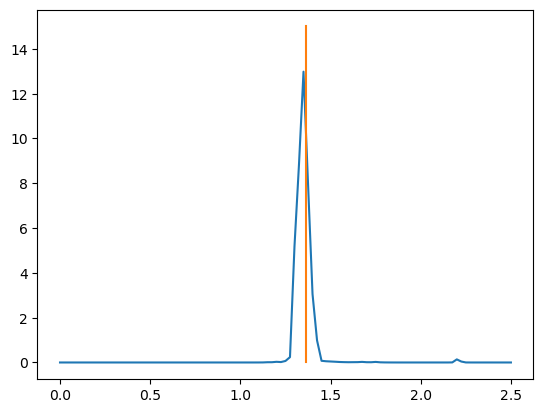

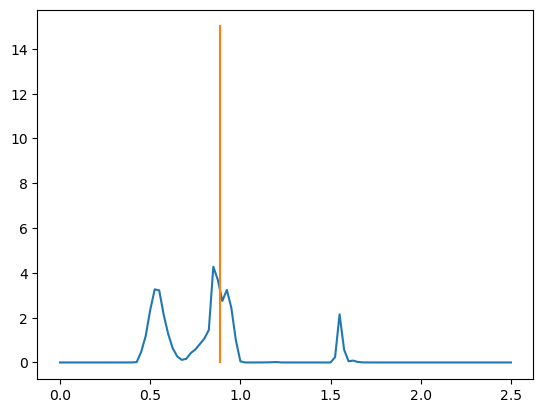

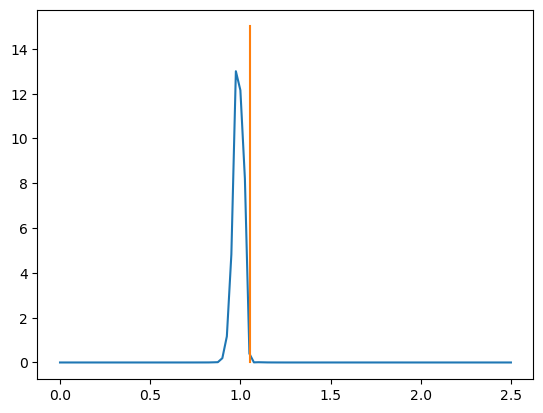

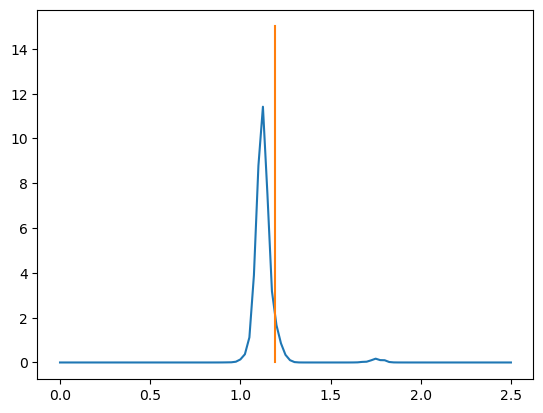

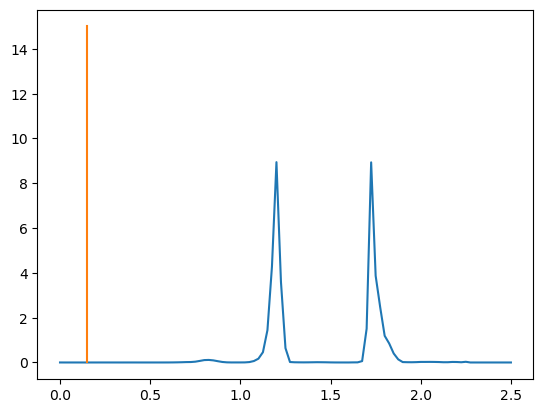

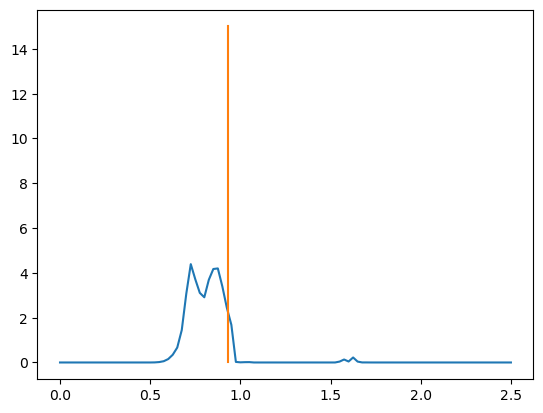

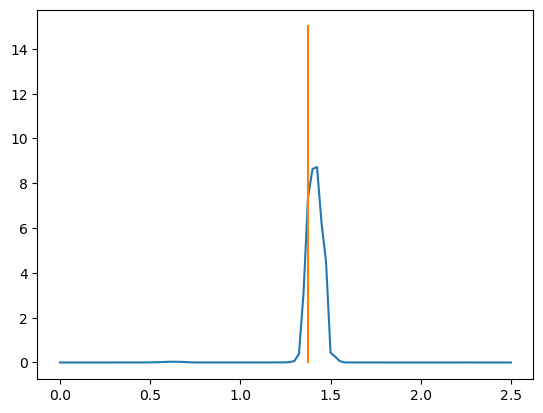

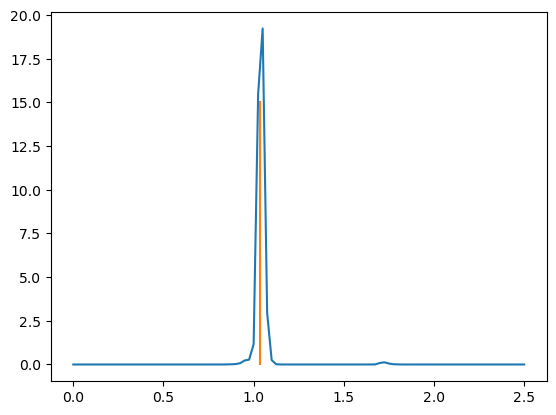

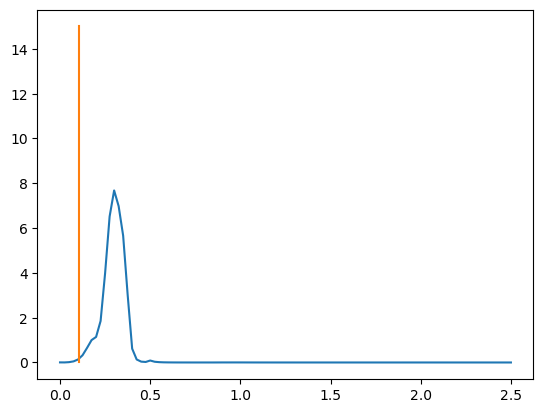

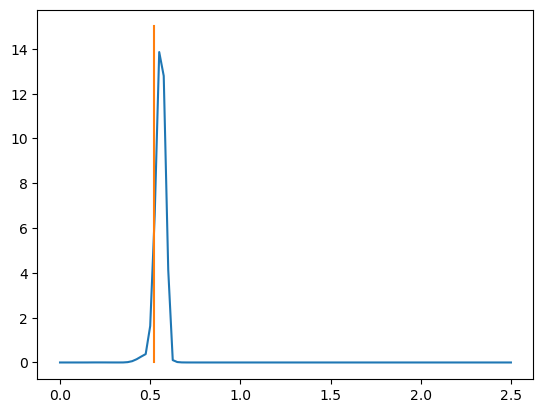

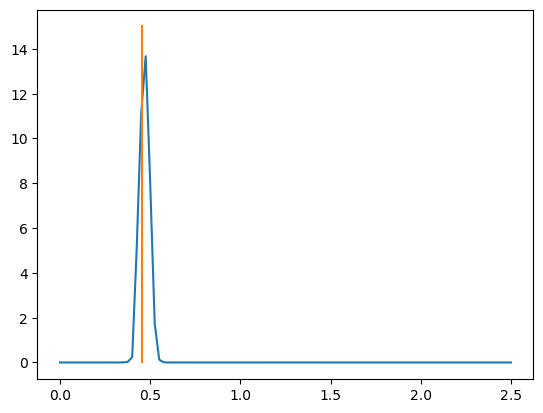

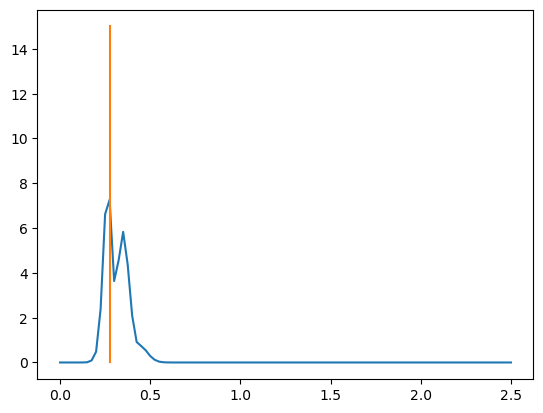

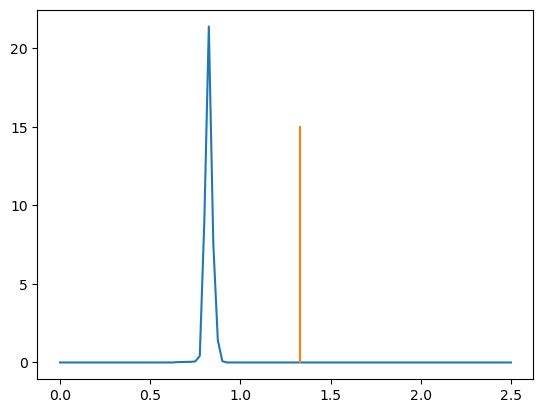

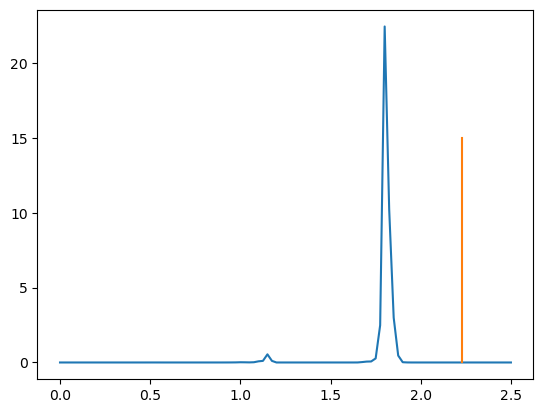

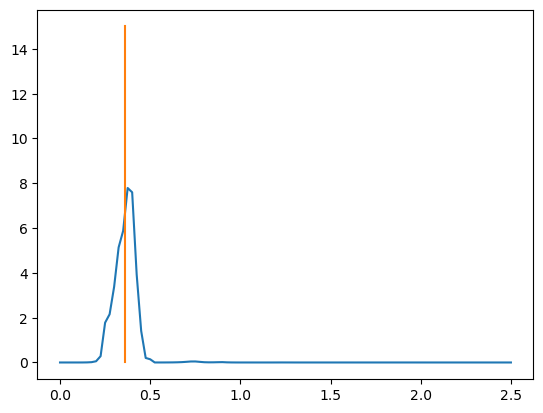

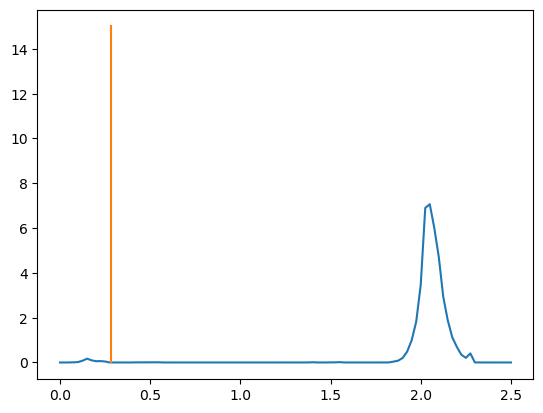

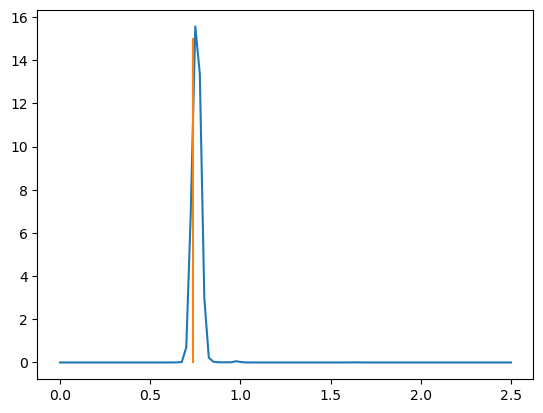

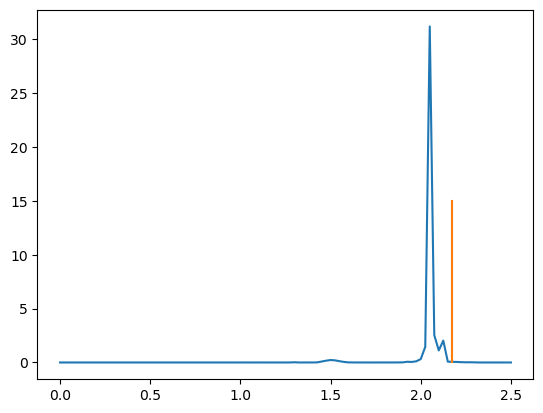

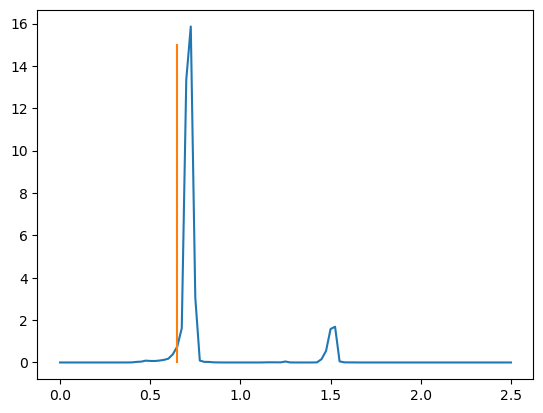

In [157]:
import matplotlib.pyplot as plt


for i in range(21, 40):

    plt.plot(file['meta']['xvals'][0], file['data']['yvals'][i])
    plt.plot(table['redshift'][i] * np.ones(len(file['meta']['xvals'][0])), np.linspace(0, 15, len(file['meta']['xvals'][0])))
    plt.show()

# Make tables

In [40]:
bands = ['u','g','r','i','z','y']
band_dict_err = {f'mag_{band}_lsst_err':f'mag_err_{band}_lsst' for band in bands}

def colRemapper_1(dict):
    col_remap = ColumnMapper.make_stage(
    name='col_remapper_1', 
    columns=dict,
    )
    return col_remap

def colRemapper_2(dict):
    col_remap = ColumnMapper.make_stage(
    name='col_remapper_2', 
    columns=dict,
    )
    return col_remap

def tableConverter():
    table_conv = TableConverter.make_stage(
    name='table_conv', 
    output_format='numpyDict',
    )
    return table_conv

In [41]:
os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/at_scale_estimation/test_data")#remapped_test_set_lsst_err_only.pq"

remap_null_train = DS.read_file("remapped_null_training_data", TableHandle, "./control_set_null_LSSTerr.pq")
remap_data = colRemapper_1(band_dict_err)(remap_null_train)



Inserting handle into data store.  output_col_remapper_1: inprogress_output_col_remapper_1.pq, col_remapper_1


In [39]:
type(remap_data)

rail.core.data.PqHandle

In [34]:
!pwd

/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/at_scale_estimation/test_data


In [21]:
help(ColumnMapper)

Help on class ColumnMapper in module rail.core.utilStages:

class ColumnMapper(rail.core.stage.RailStage)
 |  ColumnMapper(args, comm=None)
 |  
 |  Utility stage that remaps the names of columns.
 |  
 |  Notes
 |  -----
 |  1. This operates on pandas dataframs in parquet files.
 |  
 |  2. In short, this does:
 |  `output_data = input_data.rename(columns=self.config.columns, inplace=self.config.inplace)`
 |  
 |  Method resolution order:
 |      ColumnMapper
 |      rail.core.stage.RailStage
 |      ceci.stage.PipelineStage
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __call__(self, data)
 |      Return a table with the columns names changed
 |      
 |      Parameters
 |      ----------
 |      sample : Table-like
 |          The data to be renamed
 |      
 |      Returns
 |      -------
 |      table : Table-like
 |          The degraded sample
 |  
 |  __init__(self, args, comm=None)
 |      Constructor:
 |      Do RailStage specific initialization
 |  
 |  __r

# Inform & Estimate

In [18]:
def informTrainZ():
    inf = TrainZInformer.make_stage(
    name = 'inform_TrainZ',
    model = 'trainz.pkl',
    hdf5_groupname=""
    )
    return inf

def estimateTrainZ(info):
    est = TrainZEstimator.make_stage(
    name = 'estimate_TrainZ',
    model = 'trainz.pkl', 
    hdf5_groupname=""
    )
    return est

In [19]:
# help(rail.estimation.algos.cmnn)#Inform_CMNNPDF)

In [20]:
def informCMNN():
    inf = Inform_CMNNPDF.make_stage(
    name = 'inform_CMNN',
    model = 'cmnn.pkl',
    hdf5_groupname=""
    # config_options = {'err_bands': ['mag_err_u_lsst', 
    #                                 'mag_err_g_lsst'
    #                                 'mag_err_r_lsst'
    #                                 'mag_err_i_lsst'
    #                                 'mag_err_z_lsst'
    #                                 'mag_err_y_lsst'] }
    )
    return inf

def estimateCMNN(info):
    est = CMNNPDF.make_stage(
    name = 'estimate_CMNN',
    model = 'cmnn.pkl', 
    hdf5_groupname=""
    )
    return est

In [38]:
def informGPz():
    inf = GPzInformer.make_stage(
    name = 'inform_GPz',
    model = 'gpz.pkl',
    hdf5_groupname=""
    # config_options = {'err_bands': ['mag_err_u_lsst', 
    #                                 'mag_err_g_lsst'
    #                                 'mag_err_r_lsst'
    #                                 'mag_err_i_lsst'
    #                                 'mag_err_z_lsst'
    #                                 'mag_err_y_lsst'] }

    )
    return inf

def estimateGPz(info):
    est = GPzEstimator.make_stage(
    name = 'estimate_GPz',
    model = 'gpz.pkl', 
    hdf5_groupname=""
    )
    return est

In [22]:
# def informPZFlow():
#     inf = PZFlowInformer.make_stage(
#     name = 'inform_PZFlow',
#     model = 'pzflow.pkl',
#     hdf5_groupname=""
#     )
#     return inf

# def estimatePZFlow(info):
#     est = PZFlowEstimator.make_stage(
#     name = 'estimate_PZFlow',
#     model = 'pzflow.pkl', 
#     hdf5_groupname=""
#     )
#     return est

In [ ]:
## ONLY RUN THESE CELLS IN rail_6-4-24 AND ONLY FOR PZFlow; EVERYTHING ELSE RUNS IN rail---new ## 

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 
import pandas as pd
from astropy.table import QTable, Table, Column
from collections import OrderedDict

In [2]:
import rail
import qp
from rail.core.data import TableHandle
from rail.core.stage import RailStage

In [3]:
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

In [4]:
dir = "/Users/alicec03/Desktop/Summer_Research/rail_pzflow/src"
os.chdir(dir)

from rail.estimation.algos.pzflow_nf_default import PZFlowInformer, PZFlowEstimator

pzflow_dict = dict(hdf5_groupname='', output_mode = 'not_default', )


In [5]:
def informPZFlow():
    inf = PZFlowInformer.make_stage(
    name = 'inform_PZFlow', 
    model = 'pzflow.pkl', 
    num_training_epochs = 150,
    **pzflow_dict
    )
    inf._aliases = dict()
    return inf 

def estimatePZFlow():
    est = PZFlowEstimator.make_stage(
    name='estimate_pzflow',
    model='pzflow.pkl',
    **pzflow_dict, 
    chunk_size = 15000
    )
    est._aliases = dict()
    return est 

In [27]:
df1 = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_FZBoost/outputs/VVDSf02/output_specselection_VVDSf02.pq")
df2 = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_FZBoost/outputs/VVDSf02/output_lsst_error_0.pq")

In [28]:
df2

,redshift,mag_g_lsst,mag_g_lsst_err,mag_i_lsst,mag_i_lsst_err,mag_r_lsst,mag_r_lsst_err,mag_u_lsst,mag_u_lsst_err,mag_y_lsst,mag_y_lsst_err,mag_z_lsst,mag_z_lsst_err
4,1.068016,23.978469,0.011595,22.860390,0.007493,23.314348,0.007530,24.531861,0.053686,21.961038,0.011332,22.207543,0.007454
6,0.729724,24.271791,0.014487,21.572772,0.005326,22.558188,0.005782,25.978886,0.188455,20.646691,0.005927,20.985653,0.005360
13,1.206573,23.103431,0.006961,22.540720,0.006535,22.809979,0.006168,23.279126,0.018320,21.598146,0.008887,21.937022,0.006631
26,0.215827,22.794806,0.006230,21.783998,0.005459,22.063238,0.005352,23.812103,0.028652,21.490427,0.008339,21.655770,0.006052
52,0.689987,24.717080,0.020889,22.246049,0.005965,23.349481,0.007664,25.652222,0.142748,21.642794,0.009136,21.926291,0.006605
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999957,0.619409,24.688354,0.020387,23.322299,0.009799,23.897355,0.010719,25.338773,0.108888,22.966369,0.025677,23.104256,0.013302
999958,1.373877,26.298010,0.083706,23.456470,0.010741,25.293554,0.033811,27.964888,0.844511,22.196400,0.013526,22.912250,0.011513
999961,0.783317,25.258889,0.033402,22.301409,0.006054,23.643681,0.009057,32.276515,4.504955,21.443400,0.008122,21.800529,0.006320
999980,0.456077,23.431141,0.008157,21.429680,0.005260,21.917461,0.005278,24.940655,0.076896,20.753229,0.006097,21.126787,0.005451


In [29]:
lsu = df2.index[np.isnan(df2['mag_u_lsst']) ==True].tolist() 
lsg = df2.index[np.isnan(df2['mag_g_lsst']) ==True].tolist() 
lsr = df2.index[np.isnan(df2['mag_r_lsst']) ==True].tolist() 
lsi = df2.index[np.isnan(df2['mag_i_lsst']) ==True].tolist() 
lsz = df2.index[np.isnan(df2['mag_z_lsst']) ==True].tolist() 
lsy = df2.index[np.isnan(df2['mag_y_lsst']) ==True].tolist() 


print(list(set(lsu+lsg + lsr+ lsi+lsz+lsy)))


[253955, 843784, 335884, 409618, 548888, 147482, 852001, 278567, 720936, 966697, 155695, 466993, 434227, 499766, 81979, 254012, 221250, 589892, 933963, 24655, 925775, 532564, 344151, 88, 647263, 270434, 213097, 409721, 737402, 360573, 24706, 860291, 974985, 245899, 835726, 893071, 958609, 16536, 925856, 368801, 278694, 286894, 426162, 827570, 499905, 41165, 753874, 368854, 147687, 188648, 844015, 893170, 721144, 721146, 663809, 73987, 696579, 295177, 286994, 426262, 287001, 8474, 614692, 549161, 344362, 614701, 319791, 999735, 598334, 180544, 819531, 49484, 598349, 598353, 360787, 541025, 8556, 156018, 393590, 672124, 385406, 221566, 934270, 172418, 819589, 565654, 328087, 426397, 713121, 180650, 213422, 328119, 647613, 8648, 401869, 950733, 786906, 229869, 483826, 999937, 238082, 557581, 33301, 328217, 983581, 279073, 328240, 418352, 655928, 959033, 770618, 926272, 139846, 336460, 852559, 549457, 385623, 787036, 508510, 549481, 426602, 860782, 156272, 967282, 328308, 74357, 598655, 35

In [11]:
col_names = ['mag_u_lsst', 'mag_g_lsst', 'mag_r_lsst', 'mag_i_lsst', 'mag_z_lsst', 'mag_y_lsst']

loc = 0
for loc in range(0, len(df2['redshift'])):
    row = df2[loc:loc+1]
    for name in col_names:
        print(row[name])
        #if np.isnan(row[name]) == True:
            #print('AAA')
    loc += 1

# loc = 15
# row = df2[loc:loc+1]
# #print(row)
# print(row['mag_g_lsst'])

2778    23.544599
Name: mag_u_lsst, dtype: float64
2778    22.186779
Name: mag_g_lsst, dtype: float64
2778    20.760634
Name: mag_r_lsst, dtype: float64
2778    19.873499
Name: mag_i_lsst, dtype: float64
2778    19.472066
Name: mag_z_lsst, dtype: float64
2778    19.258317
Name: mag_y_lsst, dtype: float64
3614    23.413162
Name: mag_u_lsst, dtype: float64
3614    21.579618
Name: mag_g_lsst, dtype: float64
3614    20.303235
Name: mag_r_lsst, dtype: float64
3614    19.068179
Name: mag_i_lsst, dtype: float64
3614    18.714364
Name: mag_z_lsst, dtype: float64
3614    18.468911
Name: mag_y_lsst, dtype: float64
5131    24.552908
Name: mag_u_lsst, dtype: float64
5131    21.881844
Name: mag_g_lsst, dtype: float64
5131    20.330677
Name: mag_r_lsst, dtype: float64
5131    19.251941
Name: mag_i_lsst, dtype: float64
5131    30.635645
Name: mag_z_lsst, dtype: float64
5131    18.434638
Name: mag_y_lsst, dtype: float64
6751    23.715508
Name: mag_u_lsst, dtype: float64
6751    21.781027
Name: mag_g_l

In [40]:
ct = 0
for i in df2['mag_z_lsst']:
    if np.isnan(i) == True:
        ct += 1
        print(i, ct)

nan 1
nan 2
nan 3
nan 4
nan 5
nan 6
nan 7
nan 8
nan 9
nan 10
nan 11
nan 12
nan 13
nan 14
nan 15
nan 16
nan 17
nan 18
nan 19
nan 20
nan 21
nan 22
nan 23
nan 24
nan 25
nan 26
nan 27
nan 28
nan 29
nan 30
nan 31
nan 32
nan 33
nan 34
nan 35
nan 36
nan 37
nan 38
nan 39
nan 40
nan 41
nan 42
nan 43
nan 44
nan 45
nan 46
nan 47
nan 48
nan 49
nan 50
nan 51
nan 52
nan 53
nan 54
nan 55
nan 56
nan 57
nan 58
nan 59
nan 60
nan 61
nan 62
nan 63
nan 64
nan 65
nan 66
nan 67
nan 68
nan 69
nan 70
nan 71
nan 72
nan 73
nan 74
nan 75
nan 76
nan 77
nan 78
nan 79
nan 80
nan 81
nan 82
nan 83
nan 84
nan 85
nan 86
nan 87
nan 88
nan 89
nan 90
nan 91
nan 92
nan 93
nan 94
nan 95
nan 96
nan 97
nan 98
nan 99
nan 100
nan 101
nan 102
nan 103
nan 104
nan 105
nan 106
nan 107
nan 108
nan 109
nan 110
nan 111
nan 112
nan 113
nan 114
nan 115
nan 116
nan 117
nan 118
nan 119
nan 120
nan 121
nan 122
nan 123
nan 124
nan 125
nan 126
nan 127
nan 128
nan 129
nan 130
nan 131
nan 132
nan 133
nan 134
nan 135
nan 136
nan 137
nan 138
nan 

In [31]:
data1 = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_TrainZ/outputs/1.0/output_lsst_error_0.pq")
data2 = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_TrainZ/outputs/1.0/output_inv_redshift.pq")

In [32]:
data1

,redshift,mag_g_lsst,mag_g_lsst_err,mag_i_lsst,mag_i_lsst_err,mag_r_lsst,mag_r_lsst_err,mag_u_lsst,mag_u_lsst_err,mag_y_lsst,mag_y_lsst_err,mag_z_lsst,mag_z_lsst_err
0,0.966559,24.697981,0.020554,22.690358,0.006931,23.450827,0.008088,25.449445,0.119858,21.535051,0.008558,21.846427,0.006418
1,1.059953,25.621688,0.046017,24.197568,0.019213,24.823453,0.022434,26.151518,0.217748,23.274423,0.033632,23.495452,0.018242
2,0.570302,28.383380,0.471983,25.696458,0.071624,26.405758,0.090526,31.017384,3.282711,25.043283,0.159229,25.563890,0.111855
4,0.341016,26.144901,0.073134,25.286391,0.049785,25.359434,0.035836,26.514136,0.293040,25.130427,0.171511,25.008434,0.068623
5,0.712270,24.458110,0.016830,23.199302,0.009054,23.805980,0.010064,24.773335,0.066386,23.089466,0.028587,23.111844,0.013380
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,0.464899,26.762184,0.125594,25.813217,0.079409,25.891819,0.057465,32.937456,5.158052,25.129838,0.171425,25.346420,0.092465
99995,0.648156,28.863500,0.666268,25.634096,0.067777,26.697650,0.116870,27.369025,0.563287,24.914419,0.142563,25.310327,0.089577
99996,1.257911,26.128194,0.072063,25.453699,0.057758,25.807632,0.053327,25.838849,0.167406,24.394950,0.090685,24.862871,0.060318
99997,1.652583,26.951892,0.147925,25.471360,0.058670,25.992044,0.062809,NaN,NaN,24.499793,0.099426,24.991590,0.067607


In [33]:
data2

,redshift,mag_g_lsst,mag_i_lsst,mag_r_lsst,mag_u_lsst,mag_y_lsst,mag_z_lsst
0,0.966559,24.721041,22.692711,23.446445,25.300295,21.518806,21.846548
1,1.059953,25.584215,24.180773,24.818432,26.139088,23.199163,23.512583
2,0.570302,27.575546,25.843550,26.462980,28.492306,25.302023,25.566341
4,0.341016,26.198450,25.291866,25.400103,26.946693,24.973673,24.965878
5,0.712270,24.463943,23.197393,23.782991,24.921415,23.028093,23.084066
...,...,...,...,...,...,...,...
99994,0.464899,26.947382,25.712088,25.966135,27.622187,25.287737,25.510817
99995,0.648156,28.063946,25.650227,26.594429,29.282473,25.099009,25.411396
99996,1.257911,26.042486,25.415533,25.832323,26.238253,24.347881,24.835291
99997,1.652583,26.878645,25.496140,26.155291,28.357960,24.551855,24.988556


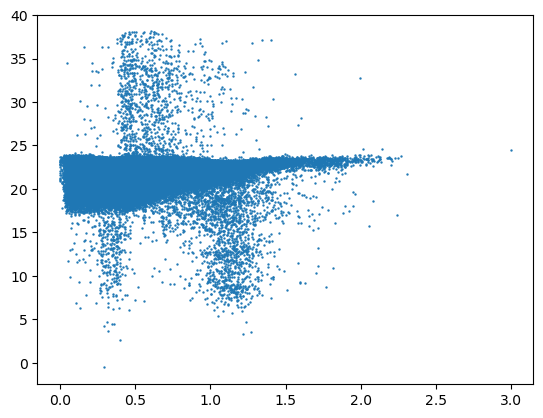

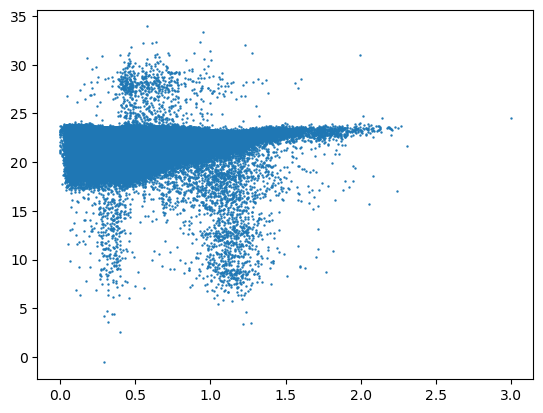

In [37]:
plt.scatter(df1['redshift'], df1['mag_z_lsst'], s=0.5)
plt.show()
plt.scatter(df2['redshift'], df2['mag_z_lsst'], s=0.5)
plt.show()

In [20]:
os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_PZFlow/outputs/BOSS/")
trainFile = DS.read_file("training_data", TableHandle, "./output_lsst_error_0.pq")

informPZFlow().inform(trainFile)

column_list None
Training 150 epochs 
Loss:
(0) inf
(1) inf
Training stopping after epoch 1 because training loss diverged.


In [42]:
os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_PZFlow/outputs/1.0/")
testFile = DS.read_file('test_data', TableHandle, "./output_lsst_error.pq")
estimatePZFlow().estimate(testFile)

column_list None
Process 0 running estimator on chunk 0 - 10000


/Users/alicec03/miniforge3/envs/rail_6-4-24/lib/python3.10/site-packages/qp/interp_pdf.py:89: RuntimeWarning: invalid value encountered in divide
  self._ycumul = (self._ycumul.T / self._ycumul[:, -1]).T


Inserting handle into data store.  output_estimate_pzflow: inprogress_output_estimate_pzflow.hdf5, estimate_pzflow


In [44]:
import h5py

os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_PZFlow/outputs/1.0/")
pzflow_out = h5py.File("./output_estimate_PZFlow.hdf5")

In [45]:
pzflow_out.keys()

<KeysViewHDF5 ['ancil', 'data', 'meta']>

In [24]:
def informFZBoost():
    info = FlexZBoostInformer.make_stage(
    name ='inform_FZBoost', 
    model ='fzboost.pkl', 
    hdf5_groupname='',
    )
    return info

def estimateFZBoost(info):
    est = FlexZBoostEstimator.make_stage(
    name='estimate_FZBoost', 
    nondetect_val=np.nan,
    model= 'fzboost.pkl', 
    hdf5_groupname='',
    # aliases=dict(input='test_data', output='fzboost_estim'),
    nzbins = 100 
    )
    return est 

In [9]:
inf_est_dict = {'TrainZ': [informTrainZ, estimateTrainZ],
               'CMNN': [informCMNN, estimateCMNN], 
               'GPz': [informGPz, estimateGPz], 
               'PZFlow': [informPZFlow, estimatePZFlow], 
               'FZBoost': [informFZBoost, estimateFZBoost]}

NameError: name 'informTrainZ' is not defined

In [26]:
# 'invz': invRedshift,

spec_dict = {'BOSS': specSelectBOSS, 
             'DEEP2': specSelectDEEP2, 
             'GAMA': specSelectGAMA,
             'HSC': specSelectHSC, 
             'VVDSf02': specSelectVVDSf02, 
             'zCOSMOS': specSelectzCOSMOS } 

inf_est_dict = {'TrainZ': [informTrainZ, estimateTrainZ],
               'CMNN': [informCMNN, estimateCMNN], 
               'GPz': [informGPz, estimateGPz], 
               'PZFlow': [informPZFlow, estimatePZFlow], 
               'FZBoost': [informFZBoost, estimateFZBoost] }

In [58]:
# import ceci 

# pr = ceci.Pipeline.read(path_lst_1[0])#parent_dir+directory+"/invz=0.33672517538070684_lsstErr_pzflow.yml")
# pr.run()

# ## 1) terminal: go to path up to invz_lsstErr_pzflow, then run these 2 lines 
# ## 2)  make list/txt file with list of paths to files made by big F

# ## do 1) 
# ## open virtual env
# ## python 
# ## import ceci 
# ## run the 2 lines of code above 


# ### at the end we can put this into a .py file that we can run at the command line 

# ## %cd ? 

In [59]:
## more config parameters/better config parameters
## have to give path above to estimator model instead of get_handle('model')
## fix truncated parameter printing in help(...)

# Big F's

In [7]:
## for inverse redshift incompleteness:

pivot_ls = [1.0, 1.4, 'control'] 

name_ls = ['BOSS', 'DEEP2', 'GAMA', 'HSC', 'VVDSf02', 'zCOSMOS']

## TrainZ

In [178]:
## HAS BEEN RUN! ##

In [223]:
def bigF0(degrader, name, pathname, ntrain, ntest, seed1, seed2, seed3, nbins, invzparam):
    
    ##things you need
    #grid = makeGrid(0, 2.5, nbins) 
    bands = ['u','g','r','i','z','y']
    band_dict = {band: f"mag_{band}_lsst" for band in bands}
    band_dict_err = {f'mag_{band}_lsst_err':f'mag_err_{band}_lsst' for band in bands}

    # modelData = makeModel()
    
    # trainData = trainSet(ntrain, seed1)

    if degrader == invRedshift:
        if invzparam == 'control':
            pass
        else:
            deg = degrader(invzparam)
    else:
        deg = degrader(ntrain) 

    # print('degrader is: '+str(deg))
    
    # testData = testSet(ntest, seed2)

    #lsstErr = lsstError(band_dict, 172)
    lsstErr_0 = lsstError_0(band_dict, seed1)

    infTrainZ = informTrainZ()
    estTrainZ = estimateTrainZ(infTrainZ)

    ##pipeline and yml
    pipe = ceci.Pipeline.interactive()
    stages = [
        #invz_train_data, 
        #spec_train_data,
        #deg, 
        lsstErr_0,
        test_data, 
        lsstErr,  
        infTrainZ, 
        estTrainZ]
    
    if degrader == invRedshift:
        stages.append(invz_train_data)
    else:
        stages.append(spec_train_data)

    if invzparam != 'control':
        stages.append(deg)


    for stage in stages:
        pipe.add_stage(stage)
    
    
    if degrader == invRedshift: 
        if invzparam =='control':
            pass
        else:
            deg.connect_input(invz_train_data)
    else:
        deg.connect_input(spec_train_data)

    #lsstErr.connect_input(test_data)
    if invzparam == 'control':
        lsstErr_0.connect_input(invz_train_data)
    else:
        lsstErr_0.connect_input(deg)

    infTrainZ.connect_input(lsstErr_0) 
    estTrainZ.connect_input(infTrainZ, inputTag = 'model')
    estTrainZ.connect_input(lsstErr, inputTag = 'input') ## trucated out of docs :(

    pipe.initialize(
    dict(model=flow_file), dict(output_dir=".", log_dir=".", resume=False), None) 

    outpath = os.path.join(pathname, "% s_lsstErr_TrainZ.yml" % name)
    pipe.save(outpath)
    return outpath 

### Specs

In [224]:
##run 

path_lst_0 = []
directory_0 = "specSelection_lsstErr_TrainZ"
parent_dir_0 = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/"
path_0 = os.path.join(parent_dir_0, directory_0)
os.makedirs(path_0, exist_ok=True)

os.chdir(path_0)

In [225]:
for key in spec_dict:
    path_lst_0.append(bigF0(spec_dict[key], key, path_0, 1000000, 10000, 17, 39, 172, 10, 0))

In [226]:
out_dir_0 = "outputs"
out_parent_dir_0 = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ"
path_outs_0 = os.path.join(out_parent_dir_0, out_dir_0)
os.makedirs(path_outs_0, exist_ok=True)



os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/outputs")

ind = 0
for i in path_lst_0:
    if ind <= 5:
        os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/outputs")
        dir_0 = name_ls[ind]
        parent_0 = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/outputs"
        outpath_0 = os.path.join(parent_0, dir_0)
        os.makedirs(outpath_0, exist_ok=True)
        os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/outputs/"+dir_0)
        pr = ceci.Pipeline.read(i)
        pr.run()
        ind += 1
    else: 
        break


# import pandas as pd
# df2 = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_TEST2/outputs/output_specselection_boss.pq")


Executing spec_train_set
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.engines.flowEngine.FlowCreator   --model=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/trained_flow.pkl   --name=spec_train_set   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/BOSS_lsstErr_TrainZ_config.yml   --output=./output_spec_train_set.pq 
Output writing to ./spec_train_set.out

Job spec_train_set has completed successfully!

Executing specselection_boss
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.degradation.spectroscopic_selections.specselection_boss   --input=./output_spec_train_set.pq   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/BOSS_lsstErr_TrainZ_config.yml   --output=./output_specselection_boss.pq 
Output writing to ./specselection_boss.out

Job specselection_boss has completed successf

In [227]:
import pandas as pd
df_BOSS = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/outputs/BOSS/output_specselection_boss.pq")
df_DEEP2 = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/outputs/DEEP2/output_specselection_deep2.pq")
df_GAMA = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/outputs/GAMA/output_specselection_gama.pq")
df_HSC = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/outputs/HSC/output_specselection_hsc.pq")
df_VVDSf02 = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/outputs/VVDSf02/output_specselection_VVDSf02.pq")
df_zCOSMOS = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/outputs/zCOSMOS/output_specselection_zCOSMOS.pq")

print(len(df_BOSS))
print(len(df_DEEP2))
print(len(df_GAMA))
print(len(df_HSC))
print(len(df_VVDSf02))
print(len(df_zCOSMOS))

1133
52105
4567
23902
137241
57704


In [228]:
import h5py
import pandas as pd

file = h5py.File("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/output_lsstErr_testSet_posts.hdf5", 'r')
file['meta'].keys()


df1 = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/output_lsst_error.pq")
df2 = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/outputs/BOSS/output_lsst_error.pq")
df3 = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/outputs/DEEP2/output_lsst_error.pq")
df4 = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_TrainZ/outputs/GAMA/output_lsst_error.pq")

df5 = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_TrainZ/outputs/1.0/output_lsst_error.pq")

df6 = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_CMNN/outputs/BOSS/output_lsst_error.pq")
df7 = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_GPz/outputs/HSC/output_lsst_error.pq")

In [229]:
df7 == df5

,redshift,mag_g_lsst,mag_g_lsst_err,mag_i_lsst,mag_i_lsst_err,mag_r_lsst,mag_r_lsst_err,mag_u_lsst,mag_u_lsst_err,mag_y_lsst,mag_y_lsst_err,mag_z_lsst,mag_z_lsst_err
0,True,True,True,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,True,True,True,True,True,True,True,True,True,True,True,True,True
9996,True,True,True,True,True,True,True,True,True,True,True,True,True
9997,True,True,True,True,True,True,True,True,True,True,True,True,True
9998,True,True,True,True,True,True,True,True,True,True,True,True,True


In [230]:
df5

,redshift,mag_g_lsst,mag_g_lsst_err,mag_i_lsst,mag_i_lsst_err,mag_r_lsst,mag_r_lsst_err,mag_u_lsst,mag_u_lsst_err,mag_y_lsst,mag_y_lsst_err,mag_z_lsst,mag_z_lsst_err
0,1.264584,27.335566,0.204859,26.010659,0.094487,26.499626,0.098303,29.226534,1.693958,24.398004,0.090929,25.209450,0.081963
1,0.364521,27.170783,0.178297,25.785038,0.077458,26.005910,0.063586,29.461337,1.883436,25.512814,0.236392,25.506251,0.106366
2,1.616940,27.210682,0.184421,26.635172,0.162388,27.314598,0.198269,30.250919,2.569135,26.751610,0.614252,26.544629,0.257191
3,1.109382,23.941152,0.011287,23.364016,0.010077,23.811488,0.010102,24.133410,0.037855,22.431205,0.016317,22.810811,0.010707
4,0.699271,26.057156,0.067677,23.890924,0.014924,24.875167,0.023455,26.324864,0.251261,23.250590,0.032933,23.440829,0.017431
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.482619,26.502169,0.100138,26.166340,0.108288,26.479355,0.096571,26.281668,0.242503,25.312048,0.199969,25.627751,0.118252
9996,0.665129,25.816069,0.054667,24.566340,0.026369,25.286158,0.033591,26.183729,0.223652,23.919040,0.059548,24.231210,0.034456
9997,2.065907,28.219786,0.417112,27.566622,0.349749,27.545993,0.240425,28.757592,1.341812,26.208213,0.411845,26.361939,0.221174
9998,0.424537,22.822369,0.006283,20.959846,0.005124,21.409214,0.005125,24.664862,0.060347,20.426450,0.005652,20.707833,0.005231


In [231]:
df3

,redshift,mag_g_lsst,mag_g_lsst_err,mag_i_lsst,mag_i_lsst_err,mag_r_lsst,mag_r_lsst_err,mag_u_lsst,mag_u_lsst_err,mag_y_lsst,mag_y_lsst_err,mag_z_lsst,mag_z_lsst_err
0,1.264584,27.335566,0.204859,26.010659,0.094487,26.499626,0.098303,29.226534,1.693958,24.398004,0.090929,25.209450,0.081963
1,0.364521,27.170783,0.178297,25.785038,0.077458,26.005910,0.063586,29.461337,1.883436,25.512814,0.236392,25.506251,0.106366
2,1.616940,27.210682,0.184421,26.635172,0.162388,27.314598,0.198269,30.250919,2.569135,26.751610,0.614252,26.544629,0.257191
3,1.109382,23.941152,0.011287,23.364016,0.010077,23.811488,0.010102,24.133410,0.037855,22.431205,0.016317,22.810811,0.010707
4,0.699271,26.057156,0.067677,23.890924,0.014924,24.875167,0.023455,26.324864,0.251261,23.250590,0.032933,23.440829,0.017431
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.482619,26.502169,0.100138,26.166340,0.108288,26.479355,0.096571,26.281668,0.242503,25.312048,0.199969,25.627751,0.118252
9996,0.665129,25.816069,0.054667,24.566340,0.026369,25.286158,0.033591,26.183729,0.223652,23.919040,0.059548,24.231210,0.034456
9997,2.065907,28.219786,0.417112,27.566622,0.349749,27.545993,0.240425,28.757592,1.341812,26.208213,0.411845,26.361939,0.221174
9998,0.424537,22.822369,0.006283,20.959846,0.005124,21.409214,0.005125,24.664862,0.060347,20.426450,0.005652,20.707833,0.005231


### invz

In [232]:
path_lst_0_invz = []
directory_0_invz = "invz_lsstErr_TrainZ"
parent_dir_0_invz = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/"
path_0_invz = os.path.join(parent_dir_0_invz, directory_0_invz)
os.makedirs(path_0_invz, exist_ok=True)

os.chdir(path_0_invz)

In [233]:
for i in pivot_ls:
    path_lst_0_invz.append(bigF0(invRedshift, 'invz='+str(i), path_0_invz, 100000, 10000, 17, 39, 172, 10, i))

In [234]:
out_dir_0_invz = "outputs"
out_parent_dir_0_invz = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_TrainZ"
path_outs_0_invz = os.path.join(out_parent_dir_0_invz, out_dir_0_invz)
os.makedirs(path_outs_0_invz, exist_ok=True)



os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_TrainZ/outputs")

ind = 0
for i in path_lst_0_invz:
    if ind < len(pivot_ls):
        os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_TrainZ/outputs")
        dir_0_invz = str(pivot_ls[ind])
        parent_0_invz = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_TrainZ/outputs"
        outpath_0_invz = os.path.join(parent_0_invz, dir_0_invz)
        os.makedirs(outpath_0_invz, exist_ok=True)
        os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_TrainZ/outputs/"+dir_0_invz)
        pr = ceci.Pipeline.read(i)
        pr.run()
        ind += 1
    else: 
        break


Executing invz_train_set
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.engines.flowEngine.FlowCreator   --model=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/trained_flow.pkl   --name=invz_train_set   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_TrainZ/invz=1.0_lsstErr_TrainZ_config.yml   --output=./output_invz_train_set.pq 
Output writing to ./invz_train_set.out

Job invz_train_set has completed successfully!

Executing inv_redshift
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.degradation.spectroscopic_degraders.InvRedshiftIncompleteness   --input=./output_invz_train_set.pq   --name=inv_redshift   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_TrainZ/invz=1.0_lsstErr_TrainZ_config.yml   --output=./output_inv_redshift.pq 
Output writing to ./inv_redshift.out

Job inv_redshift has completed successfully!


In [235]:
import pandas as pd
df1invz = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_TrainZ/outputs/1.0/output_inv_redshift.pq")
df2invz = pd.read_parquet("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_TrainZ/outputs/1.4/output_inv_redshift.pq")

print(len(df1invz))
print(len(df2invz))

85459
94504


## CMNN

In [192]:
## WE HAVE RUN THIS!! DONT RUN IT AGAIN IT TAKES AGES!! ## 

In [236]:
def bigF1(degrader, name, pathname, ntrain, ntest, seed1, seed2, seed3, nbins, invzparam):
    
    ##things you need
    #grid = makeGrid(0, 2.5, nbins) 
    bands = ['u','g','r','i','z','y']
    band_dict = {band: f"mag_{band}_lsst" for band in bands}
    band_dict_err = {f'mag_{band}_lsst_err':f'mag_err_{band}_lsst' for band in bands}

    # modelData = makeModel()
    
    # trainData = trainSet(ntrain, seed1)

    if degrader == invRedshift:
        if invzparam == 'control':
            pass
        else:
            deg = degrader(invzparam)
    else:
        deg = degrader(ntrain)   
    
    # testData = testSet(ntest, seed2)

    remapper_1 = colRemapper_1(band_dict_err)
    remapper_2 = colRemapper_2(band_dict_err)

    # lsstErr = lsstError(band_dict, seed3)
    lsstErr_0 = lsstError_0(band_dict, seed1)
    infCMNN = informCMNN()
    estCMNN = estimateCMNN(infCMNN)

    ##pipeline and yml
    pipe = ceci.Pipeline.interactive()
    stages = [
        #invz_train_data, 
        #spec_train_data,
        #deg, 
        lsstErr_0,
        remapper_1,
        test_data, 
        lsstErr,
        remapper_2, 
        infCMNN, 
        estCMNN]
    
    if degrader == invRedshift:
        stages.append(invz_train_data)
    else:
        stages.append(spec_train_data)

    if invzparam != 'control':
        stages.append(deg)


    for stage in stages:
        pipe.add_stage(stage)
        

    if degrader == invRedshift: 
        if invzparam =='control':
            pass
        else:
            deg.connect_input(invz_train_data)
    else:
        deg.connect_input(spec_train_data)


    if invzparam == 'control':
        lsstErr_0.connect_input(invz_train_data)
    else:
        lsstErr_0.connect_input(deg)


    remapper_1.connect_input(lsstErr_0)
    infCMNN.connect_input(remapper_1)

    # lsstErr.connect_input(testData)
    remapper_2.connect_input(lsstErr)
    estCMNN.connect_input(infCMNN, inputTag = 'model')
    estCMNN.connect_input(remapper_2, inputTag = 'input') ## trucated out of docs :(

    pipe.initialize(
    dict(model=flow_file), dict(output_dir=".", log_dir=".", resume=False), None) 

    outpath = os.path.join(pathname, "% s_lsstErr_CMNN.yml" % name)
    pipe.save(outpath)
    return outpath 

### Specs

In [237]:
path_lst_1 = []
directory_1 = "specSelection_lsstErr_CMNN"
parent_dir_1 = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/"
path_1 = os.path.join(parent_dir_1, directory_1)
os.makedirs(path_1, exist_ok=True)

os.chdir(path_1)

In [238]:
for key in spec_dict:
    path_lst_1.append(bigF1(spec_dict[key], key, path_1, 1000000, 10000, 17, 39, 172, 10, 0))

In [239]:
out_dir_1 = "outputs"
out_parent_dir_1 = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_CMNN"
path_outs_1 = os.path.join(out_parent_dir_1, out_dir_1)
os.makedirs(path_outs_1, exist_ok=True)



os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_CMNN/outputs")

ind = 0
for i in path_lst_1:
    if ind <= 5:
        os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_CMNN/outputs")
        dir_1 = name_ls[ind]
        parent_1 = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_CMNN/outputs"
        outpath_1 = os.path.join(parent_1, dir_1)
        os.makedirs(outpath_1, exist_ok=True)
        os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_CMNN/outputs/"+dir_1)
        pr = ceci.Pipeline.read(i)
        pr.run()
        ind += 1
    else: 
        break



Executing spec_train_set
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.engines.flowEngine.FlowCreator   --model=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/trained_flow.pkl   --name=spec_train_set   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_CMNN/BOSS_lsstErr_CMNN_config.yml   --output=./output_spec_train_set.pq 
Output writing to ./spec_train_set.out

Job spec_train_set has completed successfully!

Executing specselection_boss
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.degradation.spectroscopic_selections.specselection_boss   --input=./output_spec_train_set.pq   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_CMNN/BOSS_lsstErr_CMNN_config.yml   --output=./output_specselection_boss.pq 
Output writing to ./specselection_boss.out

Job specselection_boss has completed successfully!

E

### invz

In [240]:
path_lst_1_invz = []
directory = "invz_lsstErr_CMNN"
parent_dir = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/"
path_1_invz = os.path.join(parent_dir, directory)
os.makedirs(path_1_invz, exist_ok=True)

os.chdir(path_1_invz)

In [241]:
for i in pivot_ls:
    path_lst_1_invz.append(bigF1(invRedshift, 'invz='+str(i), path_1_invz, 100000, 10000, 17, 39, 172, 10, i))

In [242]:
out_dir_1_invz = "outputs"
out_parent_dir_1_invz = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_CMNN"
path_outs_1_invz = os.path.join(out_parent_dir_1_invz, out_dir_1_invz)
os.makedirs(path_outs_1_invz, exist_ok=True)



os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_CMNN/outputs")

ind = 0
for i in path_lst_1_invz:
    if ind < len(pivot_ls):
        os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_CMNN/outputs")
        dir_1_invz = str(pivot_ls[ind])
        parent_1_invz = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_CMNN/outputs"
        outpath_1_invz = os.path.join(parent_1_invz, dir_1_invz)
        os.makedirs(outpath_1_invz, exist_ok=True)
        os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_CMNN/outputs/"+dir_1_invz)
        pr = ceci.Pipeline.read(i)
        pr.run()
        ind += 1
    else: 
        break


Executing invz_train_set
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.engines.flowEngine.FlowCreator   --model=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/trained_flow.pkl   --name=invz_train_set   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_CMNN/invz=1.0_lsstErr_CMNN_config.yml   --output=./output_invz_train_set.pq 
Output writing to ./invz_train_set.out

Job invz_train_set has completed successfully!

Executing inv_redshift
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.degradation.spectroscopic_degraders.InvRedshiftIncompleteness   --input=./output_invz_train_set.pq   --name=inv_redshift   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_CMNN/invz=1.0_lsstErr_CMNN_config.yml   --output=./output_inv_redshift.pq 
Output writing to ./inv_redshift.out

Job inv_redshift has completed successfully!

Executi

## GPz

In [200]:
## WE HAVE RUN THIS! YAY ##

In [243]:
def bigF2(degrader, name, pathname, ntrain, ntest, seed1, seed2, seed3, nbins, invzparam):
    
    ##things you need
    #grid = makeGrid(0, 2.5, nbins) 
    bands = ['u','g','r','i','z','y']
    band_dict = {band: f"mag_{band}_lsst" for band in bands}
    band_dict_err = {f'mag_{band}_lsst_err':f'mag_err_{band}_lsst' for band in bands}

    # modelData = makeModel()
    
    # trainData = trainSet(ntrain, seed1)

    if degrader == invRedshift:
        if invzparam == 'control':
            pass
        else:
            deg = degrader(invzparam)
    else:
        deg = degrader(ntrain)  
    
    lsstErr_0 = lsstError_0(band_dict, seed1)
    remapper_1 = colRemapper_1(band_dict_err)

    # testData = testSet(ntest, seed2)
    # lsstErr = lsstError(band_dict, seed3) 
    remapper_2 = colRemapper_2(band_dict_err)

    infGPz = informGPz()
    estGPz = estimateGPz(infGPz)

    ##pipeline and yml
    pipe = ceci.Pipeline.interactive()
    stages = [
        #invz_train_data,
        #spec_train_data, 
        #deg, 
        lsstErr_0,
        remapper_1,
        test_data, 
        lsstErr,  
        remapper_2,
        infGPz, 
        estGPz]
    
    if degrader == invRedshift:
        stages.append(invz_train_data)
    else:
        stages.append(spec_train_data)

    if invzparam != 'control':
        stages.append(deg)


    for stage in stages:
        pipe.add_stage(stage)
    

    if degrader == invRedshift: 
        if invzparam =='control':
            pass
        else:
            deg.connect_input(invz_train_data)
    else:
        deg.connect_input(spec_train_data)
        

    if invzparam == 'control':
        lsstErr_0.connect_input(invz_train_data)
    else:
        lsstErr_0.connect_input(deg)


    remapper_1.connect_input(lsstErr_0)
    infGPz.connect_input(remapper_1) 

    # lsstErr.connect_input(testData)
    remapper_2.connect_input(lsstErr) 
    estGPz.connect_input(infGPz, inputTag = 'model')
    estGPz.connect_input(remapper_2, inputTag = 'input') ## trucated out of docs :(

    pipe.initialize(
    dict(model=flow_file), dict(output_dir=".", log_dir=".", resume=False), None) 

    outpath = os.path.join(pathname, "% s_lsstErr_GPz.yml" % name)
    pipe.save(outpath)
    return outpath 

### Specs

In [244]:
path_lst_2 = []
directory = "specSelection_lsstErr_GPz"
parent_dir = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/"
path_2 = os.path.join(parent_dir, directory)
os.makedirs(path_2, exist_ok=True)

os.chdir(path_2)

In [245]:
for key in spec_dict:
    path_lst_2.append(bigF2(spec_dict[key], key, path_2, 1000000, 10000, 17, 39, 172, 10, 0))

In [246]:
out_dir_2 = "outputs"
out_parent_dir_2 = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_GPz"
path_outs_2 = os.path.join(out_parent_dir_2, out_dir_2)
os.makedirs(path_outs_2, exist_ok=True)



os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_GPz/outputs")

ind = 0
for i in path_lst_2:
    if ind <= 5:
        os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_GPz/outputs")
        dir_2 = name_ls[ind]
        parent_2 = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_GPz/outputs"
        outpath_2 = os.path.join(parent_2, dir_2)
        os.makedirs(outpath_2, exist_ok=True)
        os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_GPz/outputs/"+dir_2)
        pr = ceci.Pipeline.read(i)
        pr.run()
        ind += 1
    else: 
        break



Executing spec_train_set
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.engines.flowEngine.FlowCreator   --model=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/trained_flow.pkl   --name=spec_train_set   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_GPz/BOSS_lsstErr_GPz_config.yml   --output=./output_spec_train_set.pq 
Output writing to ./spec_train_set.out

Job spec_train_set has completed successfully!

Executing specselection_boss
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.degradation.spectroscopic_selections.specselection_boss   --input=./output_spec_train_set.pq   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_GPz/BOSS_lsstErr_GPz_config.yml   --output=./output_specselection_boss.pq 
Output writing to ./specselection_boss.out

Job specselection_boss has completed successfully!

Execu

### invz

In [247]:
path_lst_2_invz = []
directory = "invz_lsstErr_GPz"
parent_dir = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/"
path_2_invz = os.path.join(parent_dir, directory)
os.makedirs(path_2_invz, exist_ok=True)

os.chdir(path_2_invz)

In [248]:
for i in pivot_ls:
    path_lst_2_invz.append(bigF2(invRedshift, 'invz='+str(i), path_2_invz, 100000, 10000, 17, 39, 172, 10, i))

In [249]:
out_dir_2_invz = "outputs"
out_parent_dir_2_invz = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_GPz"
path_outs_2_invz = os.path.join(out_parent_dir_2_invz, out_dir_2_invz)
os.makedirs(path_outs_2_invz, exist_ok=True)



os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_GPz/outputs")

ind = 0
for i in path_lst_2_invz:
    if ind < len(pivot_ls):
        os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_GPz/outputs")
        dir_2_invz = str(pivot_ls[ind])
        parent_2_invz = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_GPz/outputs"
        outpath_2_invz = os.path.join(parent_2_invz, dir_2_invz)
        os.makedirs(outpath_2_invz, exist_ok=True)
        os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_GPz/outputs/"+dir_2_invz)
        pr = ceci.Pipeline.read(i)
        pr.run()
        ind += 1
    else: 
        break


Executing invz_train_set
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.engines.flowEngine.FlowCreator   --model=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/trained_flow.pkl   --name=invz_train_set   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_GPz/invz=1.0_lsstErr_GPz_config.yml   --output=./output_invz_train_set.pq 
Output writing to ./invz_train_set.out

Job invz_train_set has completed successfully!

Executing inv_redshift
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.degradation.spectroscopic_degraders.InvRedshiftIncompleteness   --input=./output_invz_train_set.pq   --name=inv_redshift   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_GPz/invz=1.0_lsstErr_GPz_config.yml   --output=./output_inv_redshift.pq 
Output writing to ./inv_redshift.out

Job inv_redshift has completed successfully!

Executing l

## PZFlow

In [9]:
spec_ls = ['BOSS', 'DEEP2', 'GAMA', 'HSC', 'VVDSf02', 'zCOSMOS']
pivot_ls = ['1.0', '1.4', 'control']

In [10]:
pzflow_spec_dir = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_PZFlow/outputs/"
os.chdir(pzflow_spec_dir)

for spec in spec_ls:
    working_dir = pzflow_spec_dir+spec+'/'
    os.chdir(working_dir)
    trainFile = DS.read_file("training_data", TableHandle, './output_lsst_error_0.pq')
    informPZFlow().inform(trainFile)

    print("PZFlow informed on "+spec)

    testFile = DS.read_file('test_data', TableHandle, "./output_lsst_error.pq")
    estimatePZFlow().estimate(testFile)

    print("PZFlow estimated on "+spec)

column_list None
Training 150 epochs 
Loss:
(0) inf
(1) inf
Training stopping after epoch 1 because training loss diverged.
Inserting handle into data store.  model_inform_PZFlow: inprogress_pzflow.pkl, inform_PZFlow
PZFlow informed on BOSS
column_list None
Inserting handle into data store.  model: pzflow.pkl, estimate_pzflow
Process 0 running estimator on chunk 0 - 10000


/Users/alicec03/miniforge3/envs/rail_6-4-24/lib/python3.10/site-packages/qp/interp_pdf.py:89: RuntimeWarning: invalid value encountered in divide
  self._ycumul = (self._ycumul.T / self._ycumul[:, -1]).T


Inserting handle into data store.  output_estimate_pzflow: inprogress_output_estimate_pzflow.hdf5, estimate_pzflow
PZFlow estimated on BOSS
column_list None
Training 150 epochs 
Loss:
(0) inf


KeyboardInterrupt: 

In [11]:
pzflow_invz_dir = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_PZFlow/outputs/"
os.chdir(pzflow_invz_dir)

for pivot in pivot_ls:
    working_dir = pzflow_invz_dir+pivot+'/'
    os.chdir(working_dir)
    trainFile = DS.read_file("training_data", TableHandle, './output_lsst_error_0.pq')
    informPZFlow().inform(trainFile)

    print("PZFlow informed on "+pivot)

    testFile = DS.read_file('test_data', TableHandle, "./output_lsst_error.pq")
    estimatePZFlow().estimate(testFile)

    print("PZFlow estimated on "+pivot)

column_list None
Training 150 epochs 
Loss:
(0) inf
(1) inf
Training stopping after epoch 1 because training loss diverged.
PZFlow informed on 1.0
column_list None
Process 0 running estimator on chunk 0 - 10000


KeyboardInterrupt: 

### This doesnt work

In [15]:
## THIS IS BROKEN :(( ## 

In [16]:
def bigF3(degrader, name, pathname, ntrain, ntest, seed1, seed2, seed3, nbins, invzparam):
    
    ##things you need
    #grid = makeGrid(0, 2.5, nbins) 
    bands = ['u','g','r','i','z','y']
    band_dict = {band: f"mag_{band}_lsst" for band in bands}
    band_dict_err = {f'mag_{band}_lsst_err':f'mag_err_{band}_lsst' for band in bands}

    # modelData = makeModel()
    
    # trainData = trainSet(ntrain, seed1)

    if degrader == invRedshift:
        if invzparam == 'control':
            pass
        else:
            deg = degrader(invzparam)
    else:
        deg = degrader(ntrain) 
    
    # testData = testSet(ntest, seed2)

    # lsstErr = lsstError(band_dict, seed3)
    lsstErr_0 = lsstError_0(band_dict, seed1)

    #infPZFlow = informPZFlow()
    #estPZFlow = estimatePZFlow(infPZFlow)

    ##pipeline and yml
    pipe = ceci.Pipeline.interactive()
    stages = [
        #invz_train_data,
        #spec_train_data, 
        #deg, 
        lsstErr_0,
        test_data, 
        lsstErr,  
        #infPZFlow, 
        # estPZFlow
        ]
    
    if degrader == invRedshift:
        stages.append(invz_train_data)
    else:
        stages.append(spec_train_data)

    if invzparam != 'control':
        stages.append(deg)


    for stage in stages:
        pipe.add_stage(stage)


    if degrader == invRedshift: 
        if invzparam =='control':
            pass
        else:
            deg.connect_input(invz_train_data)
    else:
        deg.connect_input(spec_train_data)



    if invzparam == 'control':
        lsstErr_0.connect_input(invz_train_data)
    else:
        lsstErr_0.connect_input(deg)

    # lsstErr.connect_input(testData)

    # infPZFlow.connect_input(lsstErr_0) 
    # estPZFlow.connect_input(infPZFlow, inputTag = 'model')
    # estPZFlow.connect_input(lsstErr, inputTag = 'input') ## trucated out of docs :( 

    pipe.initialize(
    dict(model=flow_file), dict(output_dir=".", log_dir=".", resume=False), None) 

    outpath = os.path.join(pathname, "% s_lsstErr_PZFlow.yml" % name)
    pipe.save(outpath)
    return outpath 

### Specs

In [210]:
path_lst_3 = []
directory = "specSelection_lsstErr_PZFlow"
parent_dir = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/"
path_3 = os.path.join(parent_dir, directory)
os.makedirs(path_3, exist_ok=True)

os.chdir(path_3)

In [211]:
for key in spec_dict:
    path_lst_3.append(bigF3(spec_dict[key], key, path_3, 1000000, 10000, 17, 39, 172, 10, 0))

In [212]:
out_dir_3 = "outputs"
out_parent_dir_3 = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_PZFlow"
path_outs_3 = os.path.join(out_parent_dir_3, out_dir_3)
os.makedirs(path_outs_3, exist_ok=True)



os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_PZFlow/outputs")

ind = 0
for i in path_lst_3:
    if ind <= 5:
        os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_PZFlow/outputs")
        dir_3 = name_ls[ind]
        parent_3 = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_PZFlow/outputs"
        outpath_3 = os.path.join(parent_3, dir_3)
        os.makedirs(outpath_3, exist_ok=True)
        os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_PZFlow/outputs/"+dir_3)
        pr = ceci.Pipeline.read(i)
        pr.run()
        ind += 1
    else: 
        break


### invz

In [213]:
path_lst_3_invz = []
directory = "invz_lsstErr_PZFlow"
parent_dir = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/"
path_3_invz = os.path.join(parent_dir, directory)
os.makedirs(path_3_invz, exist_ok=True)

os.chdir(path_3_invz)

In [214]:
for i in pivot_ls:
    path_lst_3_invz.append(bigF3(invRedshift, 'invz='+str(i), path_3_invz, 100000, 10000, 17, 39, 172, 10, i))

In [215]:
out_dir_3_invz = "outputs"
out_parent_dir_3_invz = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_PZFlow"
path_outs_3_invz = os.path.join(out_parent_dir_3_invz, out_dir_3_invz)
os.makedirs(path_outs_3_invz, exist_ok=True)



os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_PZFlow/outputs")

ind = 0
for i in path_lst_3_invz:
    if ind < len(pivot_ls):
        os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_PZFlow/outputs")
        dir_3_invz = str(pivot_ls[ind])
        parent_3_invz = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_PZFlow/outputs"
        outpath_3_invz = os.path.join(parent_3_invz, dir_3_invz)
        os.makedirs(outpath_3_invz, exist_ok=True)
        os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_PZFlow/outputs/"+dir_3_invz)
        pr = ceci.Pipeline.read(i)
        pr.run()
        ind += 1
    else: 
        break

### PZFlow Control Workaround

In [12]:
directory = 'control'
parent_dir = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_PZFlow/outputs"
path_3_invz = os.path.join(parent_dir, directory)
os.makedirs(path_3_invz, exist_ok=True)

In [18]:
os.chdir(path_3_invz)
path = bigF3(invRedshift, 'invz=control', path_3_invz, 100000, 10000, 17, 39, 172, 10, 'control')

In [19]:
pr = ceci.Pipeline.read(path)
pr.run()


Executing invz_train_set
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.engines.flowEngine.FlowCreator   --model=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/trained_flow.pkl   --name=invz_train_set   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_PZFlow/outputs/control/invz=control_lsstErr_PZFlow_config.yml   --output=./output_invz_train_set.pq 
Output writing to ./invz_train_set.out

Job invz_train_set has completed successfully!

Executing lsst_error_0
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.degradation.lsst_error_model.LSSTErrorModel   --input=./output_invz_train_set.pq   --name=lsst_error_0   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_PZFlow/outputs/control/invz=control_lsstErr_PZFlow_config.yml   --output=./output_lsst_error_0.pq 
Output writing to ./lsst_error_0.out

Job lsst_error_0 has co

0

## FlexZBoost

In [216]:
def bigF4(degrader, name, pathname, ntrain, ntest, seed1, seed2, seed3, nbins, invzparam):
    
    ##things you need
    #grid = makeGrid(0, 2.5, nbins) 
    bands = ['u','g','r','i','z','y']
    band_dict = {band: f"mag_{band}_lsst" for band in bands}
    band_dict_err = {f'mag_{band}_lsst_err':f'mag_err_{band}_lsst' for band in bands}

    # modelData = makeModel()
    
    # trainData = trainSet(ntrain, seed1)

    if degrader == invRedshift:
        if invzparam == 'control':
            pass
        else:
            deg = degrader(invzparam)
    else:
        deg = degrader(ntrain)  
    
    lsstErr_0 = lsstError_0(band_dict, seed1)

    # testData = testSet(ntest, seed2)

    # lsstErr = lsstError(band_dict, seed3)
    infFZBoost = informFZBoost()
    estFZBoost = estimateFZBoost(infFZBoost)

    ##pipeline and yml
    pipe = ceci.Pipeline.interactive()
    stages = [
        #invz_train_data,
        #spec_train_data, 
        #deg, 
        lsstErr_0,
        test_data, 
        lsstErr,  
        infFZBoost, 
        estFZBoost]
    
    if degrader == invRedshift:
        stages.append(invz_train_data)
    else:
        stages.append(spec_train_data)

    if invzparam != 'control':
        stages.append(deg)


    for stage in stages:
        pipe.add_stage(stage)


    if degrader == invRedshift: 
        if invzparam =='control':
            pass
        else:
            deg.connect_input(invz_train_data)
    else:
        deg.connect_input(spec_train_data)


    if invzparam == 'control':
        lsstErr_0.connect_input(invz_train_data)
    else:
        lsstErr_0.connect_input(deg)


    # lsstErr.connect_input(testData)

    infFZBoost.connect_input(lsstErr_0) 
    estFZBoost.connect_input(infFZBoost, inputTag = 'model')
    estFZBoost.connect_input(lsstErr, inputTag = 'input') ## trucated out of docs :(

    pipe.initialize(
    dict(model=flow_file), dict(output_dir=".", log_dir=".", resume=False), None) 

    outpath = os.path.join(pathname, "% s_lsstErr_FZBoost.yml" % name)
    pipe.save(outpath)
    return outpath 

### Specs

In [217]:
path_lst_4 = []
directory = "specSelection_lsstErr_FZBoost"
parent_dir = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/"
path_4 = os.path.join(parent_dir, directory)
os.makedirs(path_4, exist_ok=True)

os.chdir(path_4)

In [218]:
for key in spec_dict:
    path_lst_4.append(bigF4(spec_dict[key], key, path_4, 1000000, 10000, 17, 39, 172, 10, 0))

In [219]:
out_dir_4 = "outputs"
out_parent_dir_4 = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_FZBoost"
path_outs_4 = os.path.join(out_parent_dir_4, out_dir_4)
os.makedirs(path_outs_4, exist_ok=True)



os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_FZBoost/outputs")

ind = 0
for i in path_lst_4:
    if ind <= 5:
        os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_FZBoost/outputs")
        dir_4 = name_ls[ind]
        parent_4 = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_FZBoost/outputs"
        outpath_4 = os.path.join(parent_4, dir_4)
        os.makedirs(outpath_4, exist_ok=True)
        os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_FZBoost/outputs/"+dir_4)
        pr = ceci.Pipeline.read(i)
        pr.run()
        ind += 1
    else: 
        break


Executing spec_train_set
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.engines.flowEngine.FlowCreator   --model=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/trained_flow.pkl   --name=spec_train_set   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_FZBoost/BOSS_lsstErr_FZBoost_config.yml   --output=./output_spec_train_set.pq 
Output writing to ./spec_train_set.out



Job spec_train_set has completed successfully!

Executing specselection_boss
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.degradation.spectroscopic_selections.specselection_boss   --input=./output_spec_train_set.pq   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_FZBoost/BOSS_lsstErr_FZBoost_config.yml   --output=./output_specselection_boss.pq 
Output writing to ./specselection_boss.out

Job specselection_boss has completed successfully!

Executing lsst_error_0
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.degradation.lsst_error_model.LSSTErrorModel   --input=./output_specselection_boss.pq   --name=lsst_error_0   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/specSelection_lsstErr_FZBoost/BOSS_lsstErr_FZBoost_config.yml   --output=./output_lsst_error_0.pq 
Output writing to ./lsst_error_0.out

Job lsst_error_0 has completed successfully!

Executing 

### invz

In [220]:
path_lst_4_invz = []
directory = "invz_lsstErr_FZBoost"
parent_dir = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/"
path_4_invz = os.path.join(parent_dir, directory)
os.makedirs(path_4_invz, exist_ok=True)

os.chdir(path_4_invz)

In [221]:
for i in pivot_ls:
    path_lst_4_invz.append(bigF4(invRedshift, 'invz='+str(i), path_4_invz, 100000, 10000, 17, 39, 172, 10, i))

In [222]:
out_dir_4_invz = "outputs"
out_parent_dir_4_invz = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_FZBoost"
path_outs_4_invz = os.path.join(out_parent_dir_4_invz, out_dir_4_invz)
os.makedirs(path_outs_4_invz, exist_ok=True)



os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_FZBoost/outputs")

ind = 0
for i in path_lst_4_invz:
    if ind < len(pivot_ls):
        os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_FZBoost/outputs")
        dir_4_invz = str(pivot_ls[ind])
        parent_4_invz = "/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_FZBoost/outputs"
        outpath_4_invz = os.path.join(parent_4_invz, dir_4_invz)
        os.makedirs(outpath_4_invz, exist_ok=True)
        os.chdir("/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_FZBoost/outputs/"+dir_4_invz)
        pr = ceci.Pipeline.read(i)
        pr.run()
        ind += 1
    else: 
        break


Executing invz_train_set
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.engines.flowEngine.FlowCreator   --model=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/trained_flow.pkl   --name=invz_train_set   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_FZBoost/invz=1.0_lsstErr_FZBoost_config.yml   --output=./output_invz_train_set.pq 
Output writing to ./invz_train_set.out

Job invz_train_set has completed successfully!

Executing inv_redshift
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.degradation.spectroscopic_degraders.InvRedshiftIncompleteness   --input=./output_invz_train_set.pq   --name=inv_redshift   --config=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/invz_lsstErr_FZBoost/invz=1.0_lsstErr_FZBoost_config.yml   --output=./output_inv_redshift.pq 
Output writing to ./inv_redshift.out

Job inv_redshift has completed successful